In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn_extra.cluster import KMedoids
from sklearn.feature_extraction.text import CountVectorizer
from data_parsing import load_trajectories

In [8]:
# session level edge data
trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')

In [9]:
vectorizer = CountVectorizer(ngram_range=[2,2])
url_counts = vectorizer.fit_transform(list(trajectories.apply(lambda x : " ".join([str(url) for url in x]))))
len(vectorizer.get_feature_names())

6199

In [35]:
def get_medoid_clusters(k):
    kmedoids = KMedoids(n_clusters = k).fit(url_counts)
    kmedoids.labels_

    labels = pd.DataFrame(kmedoids.labels_)
    labels['index'] = trajectories.index
    labels.to_csv('MITxPRO+LASERxB1+1T2019_kmedoids 8 clusters.csv', header = ['cluster id', 'user id'], index = False)

    clusters = []
    cluster_id = []
    for i in range(k):
        clusters.append([])
        cluster_id.append([])
        
    for i, label in enumerate(kmedoids.labels_):
        clusters[label].append(trajectories.index[i])
        cluster_id[label].append(i)
    return cluster_id

In [36]:
variance_by_k = []
ks = list(range(2,9))
for k in ks:
    cluster_id = get_medoid_clusters(k)

    cluster_variances = []
    for i in range(k):
        cluster_variances.append(url_counts.todense()[cluster_id[i]].var())
    cluster_variances = np.array(cluster_variances)
    cluster_counts = np.array([len(x) for x in cluster_id])
    variance_by_k.append((cluster_variances*cluster_counts/930).sum())
    print(cluster_variances)

[0.11270127 0.11483911]
[0.10274713 0.10491476 0.16238891]
[0.09204663 0.09739139 0.14428612 0.18022378]
[0.02314704 0.11105782 0.1289487  0.12795333 0.21309056]
[0.21206888 0.02314704 0.11040569 0.12867447 0.12733563 0.12082144]
[0.21478995 0.02314704 0.11151622 0.12867447 0.12733563 0.12082144
 0.11370201]
[0.21478995 0.02314704 0.11143136 0.12958912 0.12782523 0.12704076
 0.11370201 0.11168271]


Text(0, 0.5, 'Average inter-cluster variance')

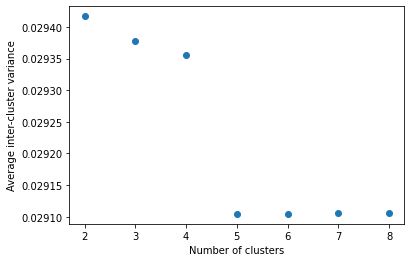

In [37]:
plt.scatter(ks, variance_by_k)
plt.xlabel('Number of clusters')
plt.ylabel('Average inter-cluster variance')

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]